In [360]:
import osmnx as ox
import networkx as nx
import pickle
import math

In [361]:
graphMiddle = "Minervahaven, Amsterdam, North Holland, Netherlands, 1013, Netherlands"
place_name = "Albert Heijn, 186, Amstelveenseweg, Schinkelbuurt, Amsterdam, North Holland, Netherlands, 1075XR, Netherlands"

In [362]:
#traffic_signals = ox.geometries.geometries_from_address(place_name, tags = {"highway":"traffic_signals"} )

In [363]:
#crossings=ox.geometries.geometries_from_address(place_name, tags = {"crossing":"marked"} )

In [364]:
#roundabouts=ox.geometries.geometries_from_address(place_name, tags = {"junction":"roundabout"} )

In [365]:
#highways = ox.geometries.geometries_from_address(place_name,dist=650, tags = {"highway":["motorway","trunk", "primary", "secondary","tertiary","unclassified", "residential","road"]} )

In [366]:
graph = ox.graph_from_address(place_name, network_type='drive',simplify = True)
#ox.distance.nearest_nodes(graph, 8.435432953597548, 47.39719131318801)
#ox.plot.plot_graph_routes(graph,["N", "N2814628451"] )

In [367]:
#CHANGE BACK TO MIDDLE
utn = ox.settings.useful_tags_node
utw = ox.settings.useful_tags_way
ox.settings.all_oneway = False
ox.settings.useful_tags_node = utn # Default is [“ref”, “highway”]
ox.settings.useful_tags_way = utw # Default is [“bridge”, “tunnel”, “oneway”, “lanes”, “ref”, “name”, “highway”, “maxspeed”, “service”, “access”, “area”, “landuse”, “width”, “est_width”, “junction”]
custom_filter='["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|residential|road"]'
G = ox.graph.graph_from_address(place_name,dist=650, network_type='drive',simplify=True, custom_filter=custom_filter)

In [368]:
def linestring_to_points(feature,line):
    return {feature:line.coords}

In [369]:
def calculate_direction(line):
    A=line[0]
    B=line[1]
    begin=math.atan2( B[1] - A[1], B[0] - A[0] ) * ( 180 / math.pi )

    C=line[-2]
    D=line[-1]
    end=math.atan2( D[1] - C[1], D[0] - C[0] ) * ( 180 / math.pi )

    return {'begin':begin, 'end':end}

In [370]:
# create nodes, edges GeoDataFrames and fill in all edge geometry attributes
# then re-create a MultiDiGraph from those GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G, fill_edge_geometry=True)
#extract the points from the LineStrings, the apply function doesn't require a dict as they remain indexed in the output DataFrame.
edges['points'] = edges.apply(lambda x: [y for y in x['geometry'].coords], axis=1)
# calculate the direction of the way at the beginning and ending (to decide ways connected but in opposite directions)
edges['directions'] = edges.apply(lambda x: calculate_direction(x['points']), axis=1)

G2 = ox.utils_graph.graph_from_gdfs(nodes, edges, graph_attrs=G.graph)
for u, v, data in G2.edges(keys=False, data=True):
    print(data)
    assert 'geometry' in data

#remove the attribute containing Linestring.
att_list = ['geometry']
for n1, n2, d in G2.edges(data=True):
    for att in att_list:
        d.pop(att, None)

{'osmid': 7381867, 'oneway': False, 'name': 'Emmalaan', 'highway': 'residential', 'maxspeed': '30', 'reversed': True, 'length': 78.455, 'geometry': <shapely.geometry.linestring.LineString object at 0x127dbedf0>, 'points': [(4.8620141, 52.3553456), (4.8624642, 52.3546958)], 'directions': {'begin': -55.2906351829105, 'end': -55.2906351829105}}
{'osmid': [39174777, 7381831], 'oneway': True, 'name': 'Koningslaan', 'highway': ['unclassified', 'residential'], 'maxspeed': '30', 'reversed': False, 'length': 151.543, 'geometry': <shapely.geometry.linestring.LineString object at 0x12b296f40>, 'points': [(4.8620141, 52.3553456), (4.8623281, 52.355412), (4.8625562, 52.3554349), (4.8628258, 52.3554319), (4.8630938, 52.3554118), (4.8634856, 52.3553418), (4.8637578, 52.3552655), (4.8638665, 52.3552362), (4.8639023, 52.3550532)], 'directions': {'begin': 11.940146626894876, 'end': -78.93110850827483}}
{'osmid': 7381832, 'oneway': True, 'name': 'Koningslaan', 'highway': 'residential', 'maxspeed': '30', 

In [371]:
#simple_G=ox.simplification.simplify_graph(G2)

Exception: This graph has already been simplified, cannot simplify it again.

In [372]:
#projected=ox.project_graph(simple_G, to_crs='EPSG:3035')
projected=ox.project_graph(G2, to_crs='EPSG:3035')
#have to work on tolerance pl:(https://nominatim.openstreetmap.org/ui/details.html?osmtype=W&osmid=89524318)
G_with_intersection = ox.simplification.consolidate_intersections(projected, tolerance=8, rebuild_graph=True, dead_ends=True, reconnect_edges=True)

In [373]:
#print(ox.projection.is_projected('EPSG:3035'))
#ox.plot_graph_folium(simple_G, node_color='g',figsize=(30,30))
#ox.plot_graph(G_with_intersection, node_color='g',figsize=(30,30))
#ox.plot_graph_folium(G,popup_attribute="osmid")


In [374]:
#nodes, edges = ox.graph_to_gdfs(G_with_intersection)

In [375]:
#nx.get_edge_attributes(G_with_intersection,name='osmid')

In [376]:
class Point:
    def __init__(self, x,y):
        self.x=x
        self.y=y

In [377]:
def is_right(a, b, c):
    return (b.x - a.x)*(c.y - a.y) > (b.y - a.y)*(c.x - a.x)
    #Cross Product
    #Where a = line point 1; b = line point 2; c = point to check against.
    #If the formula is equal to 0, the points are colinear.
    #If the line is horizontal, then this returns true if the point is above the line.

In [378]:
a = Point(47.4488,19.0714)
b = Point(47.4523,19.0714)
cl = Point(47.4557,19.0654)
cr = Point(47.4565,19.0761)
is_right(a,b,cr)

True

In [379]:
def list_duplicates(l):
    seen = set()
    seen_add = seen.add
    # adds all elements it doesn't know yet to seen and all other to seen_twice
    seen_twice = set( x for x in l if x in seen or seen_add(x) )
    # turn the set into a list (as requested)
    return list( seen_twice )

In [380]:
def get_closest_node(given, target):
    distance=9999
    for edge in G_with_intersection.edges(data=True,keys=True):

        #print(edge[3]["name"])
        if edge[3]["name"] == given:
            #print(edge)
            for edge2 in G_with_intersection.edges(data=True,keys=True):
                if edge2[3]["name"] == target:
                    if edge2[0] == edge[1] or edge2[1] == edge[0]:
                        original_id = G_with_intersection.nodes[edge[1]]["osmid_original"]
                        if type(original_id) is int:
                            nodes.append(original_id)
                        else:
                            nodes=original_id.strip('][').split(', ')

In [381]:
def find_street_end(street):
    beginWays=[]
    endWays=[]
    for way in street:
        numInWay = 0
        numOutWay = 0
        for otherway in street:
            if otherway[0] != way[1] or otherway[1] != way[0]:
                if way[0] == otherway[1]:
                    numInWay+=1
                if way[1] == otherway[0]:
                    numOutWay+=1
        if numInWay == 0 :
            beginWays.append(way)
        if numOutWay == 0 :
            endWays.append(way)

    return {"beginWays":beginWays,"endWays":endWays}

In [382]:
def recursive_find_section(street,route, direction):

    possibilites=[]
    for way in street:
        if (direction=="beginWays" and way[0] == route[-1][1] and way[1] != route[-1][0]) \
                or (direction=="endWays" and way[1] == route[-1][0] and way[0] != route[-1][1]):
            possibilites.append(way)

    if possibilites:
        closest=possibilites[0]
        for candidate in possibilites:
            print(candidate)
            if abs(candidate[3]["directions"]["begin"]-route[-1][3]["directions"]['end']) < abs(closest[3]["directions"]["begin"]-route[-1][3]["directions"]['end']):
                closest=candidate
        route.append(closest)
        #street.remove(possibilites[-1])
        return recursive_find_section(street,route, direction)
    return route

In [383]:
def find_street_section(street,street_ends, direction):
    streetSections=[]

    for beginWay in street_ends[direction]:
        beginRoute=[beginWay]
        route=recursive_find_section(street,beginRoute, direction)
        streetSections.append(route)
    return streetSections

In [384]:
def sort_street(street):
    street_ends=find_street_end(street) # correct
    streetSectionsForward=find_street_section(street,street_ends,"beginWays")
    streetSectionsBackward=find_street_section(street,street_ends,"endWays")

    return {"forward":streetSectionsForward,"backward":streetSectionsBackward}

In [385]:
def organise_edge_of_street(street,graph):
    edges=[]
    nodes,EDGES=ox.graph_to_gdfs(graph)
    for edge in graph.edges(data=True,keys=True):
    #for index, edge in EDGES.iterrows():
        #Check if a given key already exists in a dictionary
        if edge[3]["highway"] != 'busway':
            if "name" in edge[3]:
                if isinstance(edge[3]["name"], str):
                    if edge[3]["name"] == street:
                        edges.append(edge)
                else:
                    for name in edge[3]["name"]:
                        if name == street:
                            edges.append(edge)
    return sort_street(edges)

In [386]:
def get_nodes_of_way(ways):

    #nodes=[ways[0][3]["u_original"]]
    #for way in ways:
    #    nodes.append(way[3]["v_original"])

    nodes=[ways[0][0]]
    for way in ways:
        nodes.append(way[1])

    return nodes

In [387]:

path=[]
streetName="Amstelveenseweg"
for edge in G_with_intersection.edges(data=True,keys=True):
    #Check if a given key already exists in a dictionary
    nodes=[]
    if edge[3]["highway"] != 'busway':
        if "name" in edge[3]:
            if isinstance(edge[3]["name"], str):
                if edge[3]["name"] == streetName:
                    nodes=[edge[0],edge[1]]
            else:
                for name in edge[3]["name"]:
                    if name == streetName:
                        nodes=[edge[0],edge[1]]
    if nodes:
        path.append(nodes)
print(path)
#ox.plot_graph_route(G_with_intersection, path[0],figsize=(30,30))

[[8, 9], [8, 13], [9, 8], [9, 12], [12, 151], [12, 9], [13, 186], [40, 49], [49, 57], [53, 52], [86, 101], [97, 53], [101, 106], [106, 112], [112, 140], [112, 141], [134, 136], [134, 137], [136, 134], [136, 140], [137, 134], [137, 151], [140, 112], [140, 136], [141, 102], [151, 137], [151, 12], [186, 8], [198, 186]]


In [406]:
street = organise_edge_of_street("Amstelveenseweg",G2)
greaph_G_with_intersection = ox.graph_to_gdfs(G2)


(46281852, 46288281, 0, {'osmid': [7381707, 666428615], 'oneway': True, 'name': 'Amstelveenseweg', 'highway': 'secondary', 'maxspeed': '50', 'reversed': False, 'length': 199.704, 'lanes': '1', 'points': [(4.8577735, 52.3476374), (4.8577528, 52.3483889), (4.8577424, 52.3486956), (4.8577307, 52.349088), (4.857725, 52.3492874), (4.8577452, 52.3493428), (4.8577538, 52.3493663), (4.857789, 52.3494275)], 'directions': {'begin': 91.57780814179885, 'end': 60.094062823954374}})
(46293426, 46295648, 0, {'osmid': 666428612, 'oneway': True, 'name': 'Amstelveenseweg', 'highway': 'secondary', 'maxspeed': '50', 'reversed': False, 'length': 57.109, 'lanes': '2', 'points': [(4.8571322, 52.350564), (4.8569122, 52.3510597)], 'directions': {'begin': 113.93245355837927, 'end': 113.93245355837927}})
(46295648, 7213967681, 0, {'osmid': [666428612, 772699767], 'oneway': True, 'name': 'Amstelveenseweg', 'highway': 'secondary', 'maxspeed': '50', 'reversed': False, 'length': 54.882, 'lanes': '2', 'points': [(4.8

In [412]:
def get_junction_from_distance(node,way,distance):
    #assumes direction is calculated
    for i, begin in enumerate(way):
        if begin[0]==node:
            currentDistance=begin[3]['length']
            nextDistancesByIndex=[0]
            for j, junction in enumerate(way, i+1):
                nextDistancesByIndex.append(currentDistance)
                currentDistance+=junction[3]['length']
            closestIndex=0
            for index,dst in enumerate(nextDistancesByIndex):
                if abs(dst-distance) < abs(nextDistancesByIndex[closestIndex]-distance):
                    closestIndex=index
            return way[i+closestIndex]

In [415]:
print(get_junction_from_distance(7213967683,street['forward'][1], 300))

(46309533, 46311177, 0, {'osmid': 541380595, 'oneway': False, 'name': 'Amstelveenseweg', 'highway': 'secondary', 'maxspeed': '50', 'reversed': True, 'length': 35.027, 'lanes': '2', 'points': [(4.855622, 52.3541907), (4.8555674, 52.3543308), (4.8555208, 52.3544994)], 'directions': {'begin': 111.29193839803162, 'end': 105.45047058365778}})


In [416]:
def get_junction_from_ordinal(node,way,ordinal):
    #assumes direction is calculated
    for i, begin in enumerate(way):
        if begin[0]==node:
            return way[ordinal+i]

[46291478, 46293426, 46295648, 7213967681, 7213967683, 6932152175, 6932152173, 6932152172, 46305046, 46307138, 46309533, 46311177, 5333535440, 1419351736, 46325004, 9515245671, 3296374005]


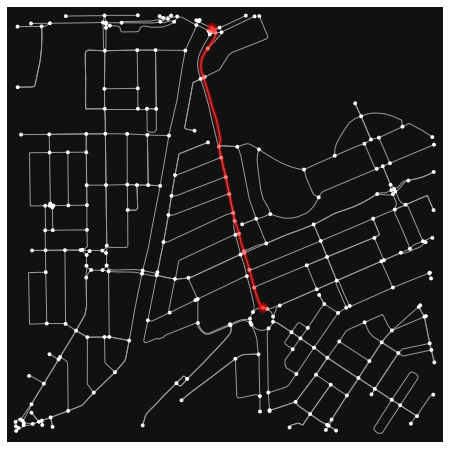

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [389]:
p=get_nodes_of_way(street['forward'][1])
print(p)
ox.plot_graph_route(simple_G, p)

In [390]:
def get_intersection_of_streets(first, second):
    #n = edges.query(f"lanes=='1'")
    #print(n)
    #print(G_with_intersection.nodes)
    #n = 'Archangelkade'
    #m= 'Rigakade'
    #print(edges.name)
    #GeoDataFrame(edges, edges.name == 'n')
    #e = edges.explore(name==n)
    nodes = []
    for edge in G_with_intersection.edges(data=True,keys=True):

        #print(edge[3]["name"])
        if hasattr(3, 'name'):
            if edge[3]["name"] == first:
                #print(edge)
                for edge2 in G_with_intersection.edges(data=True,keys=True):
                    if edge2[3]["name"] == second:
                        if edge2[0] == edge[1] or edge2[1] == edge[0]:
                            original_id = G_with_intersection.nodes[edge[1]]["osmid_original"]
                            if type(original_id) is int:
                                nodes.append(original_id)
                            else:
                                nodes=original_id.strip('][').split(', ')

                        #if type
                        #nodes.append(G_with_intersection.nodes[edge[1]]["osmid_original"].strip('][').split(', '))
    #e.head()
    #list = e.index[e['ref'] == n].tolist()
    #for road in list:
    #    print(road[1])
    # get nodes only at the intersection
    nodes = list_duplicates(nodes)
    print(nodes)
    return nodes

In [391]:
def find_shortest_path(origin,destination):
    #origin = "Albert Heijn Distributiecentrum, 1, Hoofdtocht, Westerspoor, Zaandam, Zaanstad, North Holland, Netherlands, 1507CH, Netherlands"

    #destination = "Albert Heijn, 186, Amstelveenseweg, Schinkelbuurt, Amsterdam, North Holland, Netherlands, 1075XR, Netherlands"
    #destination = 'Sassenheimstraat, Hoofddorperpleinbuurt, Amsterdam, North Holland, Netherlands, 1059AM, Netherlands'

        #if(highways.index[h['name'] == destination].tolist() or road["ref"] == destination):
        #    roadsDestination.append(road.osmid)
    # Get origin x and y coordinates
    orig_y, orig_x = ox.geocoder.geocode(origin)

    # Get target x and y coordinates
    target_y, target_x =ox.geocoder.geocode(destination)
    # Find the node in the graph that is closest to the origin point (here, we want to get the node id)
    orig_node = ox.distance.nearest_nodes(G, orig_x, orig_y )

    # Find the node in the graph that is closest to the target point (here, we want to get the node id)
    target_node = ox.distance.nearest_nodes(G, target_x, target_y)

    route=  nx.shortest_path(G, orig_node, target_node)

    #print(orig_node, target_node)
    # Get shortest path

    # Plot the shortest path
    #ox.plot_graph_route(G, route)
    return route

In [392]:
#get_intersection_of_streets('A10','A4')

In [393]:
# h = highways.to_dict()
#h = pd.Series(highways.values, index=highways.index).to_dict()
n = 'A10'
#h = highways.query(f"ref=='{n}'")
#print(h)
print(G.nodes.get(key=7549548760))
#for road in h.index[h['ref'] == n].tolist():
    #print(nodes.get(key=6316199))
#unique_ids = h.groupby('osmid', as_index=False).first()
#print(unique_ids.key[0])

NameError: name 'highways' is not defined

In [ ]:
#nodes, edges = ox.graph_to_gdfs(G)
print(G.nodes.get(key=6932152172))
#nodes.head()

In [ ]:
edges.head()
#G.edges.get(key=46319974)

In [ ]:
coord = ox.geocoder.geocode(place_name)

area = ox.geocode_to_gdf(["N2814628451"],by_osmid=True)


In [ ]:
#ox.plot_graph_folium(simple_G)

In [394]:
#ox.plot_graph_folium(G)

In [395]:
file = '../../Data/AH/Amstelveenseweg 186.txt'
%run NLP.py {file}

Haarlemmerdijk 1
__name__ ['NLP.py', '../../Data/AH/Amstelveenseweg', '186.txt']


[NbConvertApp] Converting notebook NLP.ipynb to script
[NbConvertApp] Writing 8751 bytes to NLP.py
[NbConvertApp] Converting notebook map.ipynb to script
[NbConvertApp] Writing 14744 bytes to map.py


In [396]:
def readFile(address):
    with open(f'../../Data/Routes/{address}.pickle', 'rb') as file:
        return pickle.load(file)

In [397]:
address = 'Amstelveenseweg 186'
Route=readFile(address)
last_step = 'Coentunnelweg'
path = []#get_intersection_of_streets(last_step,last_step)
print(path, type(path))
for step in Route.steps:
    try:
        street = step.data['street']
        print(street)
        r = get_intersection_of_streets(last_step,street)
        print(r)
        last_step = street
        path.extend(r)
        #assert x
    except KeyError as AssertionError:
        pass
end = find_shortest_path(last_step,Route.destination)
path.extend(end)
print(path)
#path = sum(path, [])
#path = list(dict.fromkeys(path))

[] <class 'list'>
S106
[]
[]
Amstelveenseweg
[]
[]
[46278083, 46279447, 46280752, 9384586423, 46281852, 46288281, 46289500, 566457236, 46290709, 46291478, 46293426, 46295648, 7213967681, 7213967683, 6932152175, 6932152173]


In [398]:
#ox.folium.plot_route_folium(G, path, popup_attribute="name")

In [399]:
#print(nx.has_path(G,4721896455, 735062608))
#print(nx.shortest_path(G,4721896455, 735062608))
#path = [item for sublist in path]
origin = 'Kolkweg, Oostzaan, North Holland, Netherlands, 1511HZ, Netherlands'
destination ='Amstelveenseweg 186'
orig_y, orig_x = ox.geocoder.geocode(origin)

    # Get target x and y coordinates
target_y, target_x =ox.geocoder.geocode(destination)
    # Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node = ox.distance.nearest_nodes(G, orig_x, orig_y )

    # Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.distance.nearest_nodes(G, target_x, target_y)

#route=  nx.shortest_path(G, orig_node, target_node)

#print(list(dict.fromkeys(path)))
#flatPath = sum(path, [])
#print(flatPath)
#r = [7382978,7382982]


In [418]:
!jupyter nbconvert --to script *.ipynb

[NbConvertApp] Converting notebook NLP.ipynb to script
[NbConvertApp] Writing 8751 bytes to NLP.py
[NbConvertApp] Converting notebook map.ipynb to script
[NbConvertApp] Writing 15716 bytes to map.py


In [401]:
n1 = 46494259
n2 = 3657588020
r=  nx.shortest_path(G, n1, n2)
ox.plot_graph_route(G, r)

NodeNotFound: Either source 46494259 or target 3657588020 is not in G